In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score,auc, classification_report

C:\Users\Administrator\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Administrator\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [228]:
image_info_change = pd.read_csv('./image_info_change.csv')
image_info_label = pd.read_csv('./image_info_label.csv')

In [213]:
image_info_change.head()

,image_id,image_run_date_amount,image_create_role_pay_num,image_create_role_num,image_create_role_pay_sum,image_source_num,image_create_role_pay_rate,image_create_role_cost,image_create_role_pay_cost,image_valid_source_num,...,comment,like,dislike,report,image_create_role_retain_1d,create_role_30_pay_sum,model_run_datetime,label,pred,score
0,17605,0.062,-0.962,-0.447,-0.128,-0.147,-0.962,-0.657,-1.462,2,...,0.265,-0.633,-0.115,0.216,0.708,278.0,2020-01-01 00:00:00,0,0.312506,566
1,18936,-0.487,-0.962,-0.447,-0.896,-0.147,-0.962,-0.657,-1.429,2,...,0.599,-0.633,-0.115,0.216,-0.293,6082.0,2020-01-01 00:00:00,1,0.911618,700
2,19414,0.624,-0.447,0.428,-0.128,0.459,-0.962,-0.577,-1.429,1,...,0.441,0.396,-0.115,0.216,-0.293,196.0,2020-01-01 00:00:00,0,0.198478,540
3,19431,0.763,-0.447,0.994,0.746,0.459,-0.246,1.410,-1.429,1,...,0.599,0.550,-0.115,0.216,0.687,60.0,2020-01-01 00:00:00,0,0.053504,476
4,16276,0.742,0.693,0.637,0.746,0.459,0.476,-0.577,0.854,0,...,0.599,0.563,-0.115,0.216,0.687,636.0,2020-01-01 00:00:00,1,0.520947,603


In [229]:
test_id = np.random.choice(image_info_change['image_id'].unique(),300)

In [230]:
test_date = image_info_change[image_info_change['image_id'].isin(test_id)]
train_date = image_info_change[~image_info_change['image_id'].isin(test_id)]

In [231]:
train_date.shape

(10153, 40)

In [232]:
test_date.shape

(3973, 40)

In [233]:
select_feature = ['image_run_date_amount', 'image_create_role_pay_num',
       'image_create_role_num', 'image_create_role_pay_sum',
       'image_source_num', 'image_create_role_pay_rate',
       'image_create_role_cost', 'image_create_role_pay_cost',
       'image_valid_source_rate',
       'image_pay_sum_ability', 'image_pay_num_ability',
       'image_create_role_roi', 'total_play', 'valid_play',
       'play_over',
       'play_duration_5s_rate', 'share', 'comment', 'like', 'dislike',
       'report', 'image_create_role_retain_1d', 'label']

In [234]:
x_train = train_date[select_feature].drop('label',axis=1)
y_train = train_date['label']
x_test = test_date[select_feature].drop('label',axis=1)
y_test = test_date['label']

### RandomForestClassifier

In [235]:
RF = RandomForestClassifier()
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 100, 150,200,250,300],
           "max_depth" : [2,3,4,5,6,7,8,9,10,11,12,13],
           "min_samples_leaf" : [1,2,3,4,5,6,7,8]}
RF_random = RandomizedSearchCV(RF, param_distributions=param_grid, cv=5)
RF_random.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8],
                                        'n_estimators': [9, 18, 27, 36, 100,
                                                         150, 200, 250, 300]})

In [236]:
RF_random.best_params_

{'n_estimators': 200, 'min_samples_leaf': 7, 'max_depth': 2}

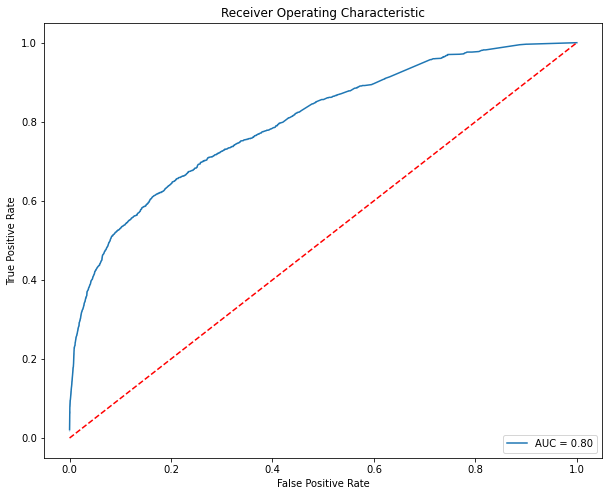

In [237]:
# 训练集评估
best_est_RF = RF_random.best_estimator_
y_pred = best_est_RF.predict_proba(x_train)
y_pred = y_pred[:,1]
fpr,tpr,_ = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

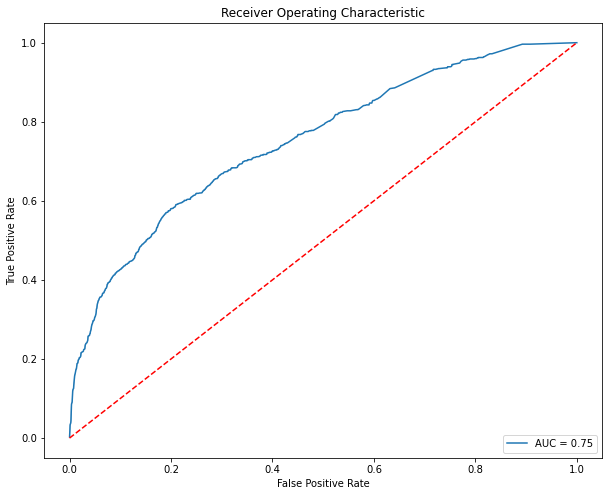

In [245]:
# 测试集评估
best_est_RF = RF_random.best_estimator_
y_pred = best_est_RF.predict_proba(x_test)
y_pred = y_pred[:,1]
fpr,tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [246]:
y_pred_class = list(map(lambda x:1 if x>=0.35 else 0, y_pred))
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2905
           1       0.54      0.52      0.53      1068

    accuracy                           0.75      3973
   macro avg       0.68      0.68      0.68      3973
weighted avg       0.75      0.75      0.75      3973



### XGB

In [254]:
from xgboost import XGBClassifier
XGB = XGBClassifier(n_jobs=-1) 
 
param_grid = {
                  'n_estimators' :[100,150,200,250,300],
                  "learning_rate" : [0.001,0.01,0.0001,0.05, 0.10 ],
                  "gamma"            : np.linspace(0,1,20),
                  "colsample_bytree" : [0.5,0.7,0.8,0.9],
                  'max_depth': [3,4,6,8,10,12,15,20,25,30]
              }
XGB_random = RandomizedSearchCV(XGB, param_distributions=param_grid, cv=5)
XGB_random.fit(x_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.8,
                                                             0.9],
                                      

In [241]:
XGB_random.best_params_

{'n_estimators': 300,
 'max_depth': 10,
 'learning_rate': 0.0001,
 'gamma': 0.8421052631578947,
 'colsample_bytree': 0.7}

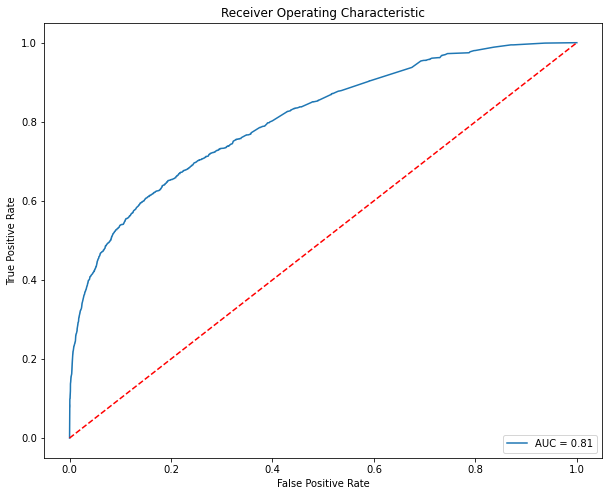

In [255]:
# 训练集评估
best_est_XGB = XGB_random.best_estimator_
y_pred = best_est_XGB.predict_proba(x_train)
y_pred = y_pred[:,1]
fpr,tpr,_ = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

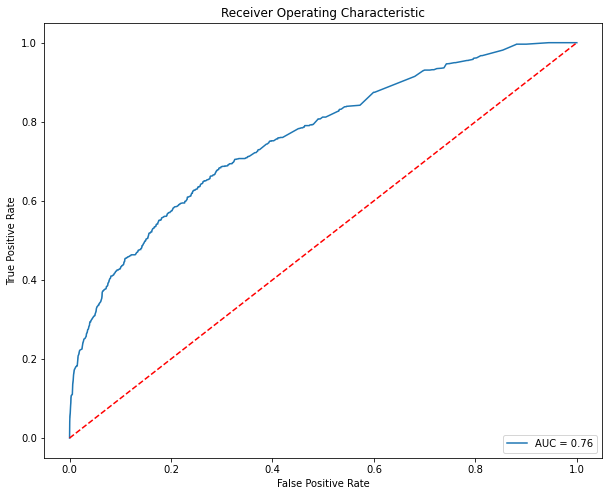

In [256]:
# 测试集评估
best_est_XGB = XGB_random.best_estimator_
y_pred = best_est_XGB.predict_proba(x_test)
y_pred = y_pred[:,1]
fpr,tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [260]:
y_pred_class = list(map(lambda x:1 if x>=0.5 else 0, y_pred))
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      2905
           1       0.65      0.40      0.50      1068

    accuracy                           0.78      3973
   macro avg       0.73      0.66      0.68      3973
weighted avg       0.77      0.78      0.76      3973



### LGB

In [261]:
from lightgbm import LGBMClassifier
LGB = LGBMClassifier(boosting_type='gbdt',objective = 'binary',metric = 'auc',n_jobs=-1) 
param_grid = {
              'max_depth': [5,10,15, 20, 25, 30, 35],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'feature_fraction': [0.4,0.5,0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_fraction': [0.4,0.5,0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_freq': [2, 4, 5, 6, 8],
              'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6,0.7,0.8,0.9],
              'lambda_l2': [0, 10, 15, 35, 40],
              'cat_smooth': [1, 10, 15, 20, 35]
}
LGB_random = RandomizedSearchCV(LGB, param_distributions=param_grid, cv=5)
LGB_random.fit(x_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(metric='auc', objective='binary'),
                   param_distributions={'bagging_fraction': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 0.95],
                                        'bagging_freq': [2, 4, 5, 6, 8],
                                        'cat_smooth': [1, 10, 15, 20, 35],
                                        'feature_fraction': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 0.95],
                                        'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6,
                                                      0.7, 0.8, 0.9],
                                        'lambda_l2': [0, 10, 15, 35, 40],
                                        'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.15],
                                        'max_depth': [5, 10, 15

In [262]:
LGB_random.best_params_

{'max_depth': 35,
 'learning_rate': 0.02,
 'lambda_l2': 40,
 'lambda_l1': 0.8,
 'feature_fraction': 0.6,
 'cat_smooth': 15,
 'bagging_freq': 5,
 'bagging_fraction': 0.5}

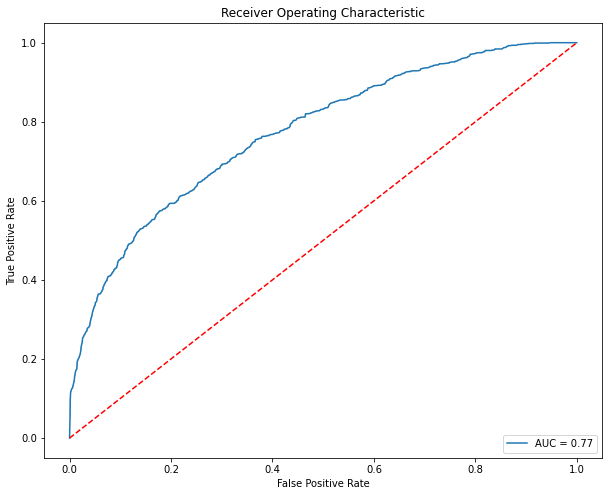

In [263]:
# 测试集评估
best_est_LGB = LGB_random.best_estimator_
y_pred = best_est_LGB.predict_proba(x_test)
y_pred = y_pred[:,1]
fpr,tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [264]:
y_pred_class = list(map(lambda x:1 if x>=0.35 else 0, y_pred))
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2905
           1       0.59      0.51      0.55      1068

    accuracy                           0.77      3973
   macro avg       0.71      0.69      0.70      3973
weighted avg       0.77      0.77      0.77      3973



### LR

In [51]:
LR = LogisticRegression()
param_grid = {"C" : [0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9, 1]}
LR_random = RandomizedSearchCV(LR, param_distributions=param_grid, cv=5)
LR_random.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                              0.8, 0.9, 1]})

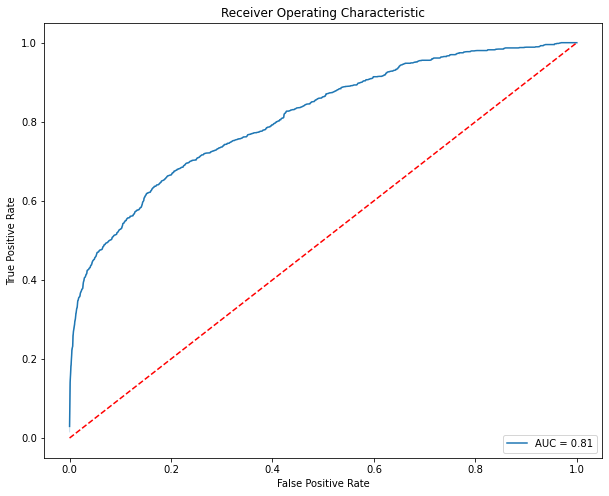

In [52]:
# 测试集评估
best_est_LR = LR_random.best_estimator_
y_pred = best_est_LR.predict_proba(x_test)
y_pred = y_pred[:,1]
fpr,tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [53]:
y_pred_class = list(map(lambda x:1 if x>=0.35 else 0, y_pred))
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2626
           1       0.64      0.57      0.60      1057

    accuracy                           0.78      3683
   macro avg       0.74      0.72      0.73      3683
weighted avg       0.78      0.78      0.78      3683



In [269]:
y_pred = 0.3* best_est_XGB.predict_proba(x_test)[:,1] + 0.4*best_est_LGB.predict_proba(x_test)[:,1] + 0.3*best_est_RF.predict_proba(x_test)[:,1]

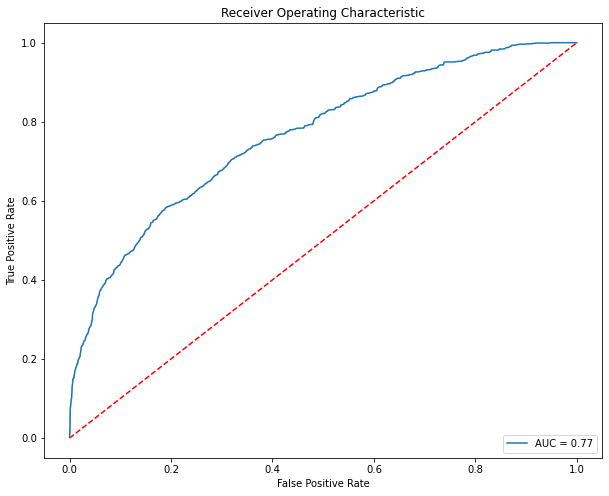

In [270]:
fpr,tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [271]:
y_pred_class = list(map(lambda x:1 if x>=0.35 else 0, y_pred))
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82      2905
           1       0.51      0.59      0.55      1068

    accuracy                           0.74      3973
   macro avg       0.68      0.69      0.68      3973
weighted avg       0.75      0.74      0.74      3973



### 转为分数

In [272]:
feature = image_info_change[select_feature].drop('label',axis=1)
image_info_change['pred'] = 0.3* best_est_XGB.predict_proba(feature)[:,1] + 0.4*best_est_LGB.predict_proba(feature)[:,1] + 0.3*best_est_RF.predict_proba(feature)[:,1]

In [273]:
y_pred_class = list(map(lambda x:1 if x>=0.3 else 0, image_info_change['pred']))
print(classification_report(image_info_change['label'], y_pred_class))

              precision    recall  f1-score   support

           0       0.87      0.68      0.76     10151
           1       0.48      0.75      0.58      3975

    accuracy                           0.70     14126
   macro avg       0.67      0.71      0.67     14126
weighted avg       0.76      0.70      0.71     14126



In [274]:
def Prob2Score(prob, basePoint=600, PDO=30):
    #将概率转化成分数且为正整数
    y = np.log(prob/(1-prob))
    return (basePoint+int(PDO/np.log(2)*(y)))

In [283]:
Prob2Score(0.3)

564

In [275]:
image_info_change['score'] = image_info_change['pred'].apply(Prob2Score)

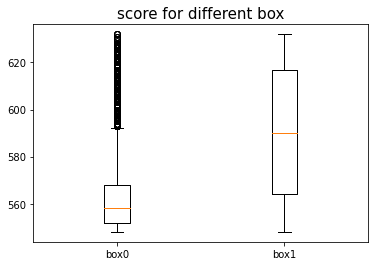

In [276]:
box0 = image_info_change[image_info_change['label']==0]['score']
box1 = image_info_change[image_info_change['label']==1]['score']
plt.title('score for different box',fontsize=15)
labels = 'box0','box1'
plt.boxplot([box0,box1],labels=labels)
plt.show()

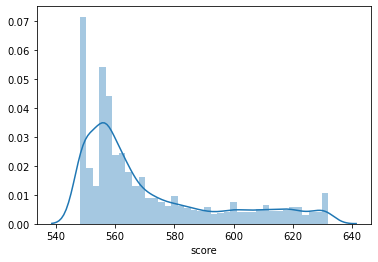

In [277]:
sns.distplot(image_info_change['score'])
plt.show()

In [278]:
image_info_label['score'] = image_info_change['score']

In [294]:
image_info_label_test = image_info_label[image_info_label['image_id'].isin(test_id)]

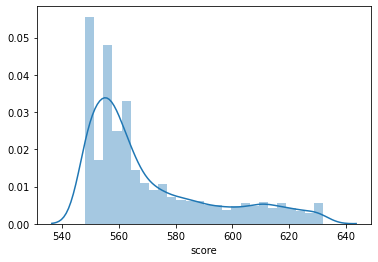

In [296]:
sns.distplot(image_info_label_test['score'])
plt.show()

In [299]:
image_info_change['pred'].min()

0.22926666567110698

In [297]:
image_info_label_test['score'].min()

548

In [295]:
image_info_label_test['score'].mean()

570.4127863075761

In [306]:
image_info_label_test[image_info_label_test['score']>=560]['create_role_30_pay_sum'].sum() / image_info_label_test[image_info_label['score']>=560]['image_run_date_amount'].sum()

0.5631291393547645

In [307]:
image_info_label_test[image_info_label_test['score']<560]['create_role_30_pay_sum'].sum() / image_info_label_test[image_info_label_test['score']<560]['image_run_date_amount'].sum()

0.39811249904621215

In [302]:
image_info_label_test[image_info_label_test['score']<600]['create_role_30_pay_sum'].sum() / image_info_label_test[image_info_label_test['score']<600]['image_run_date_amount'].sum()

0.4322790637816184

In [303]:
image_info_label_test[image_info_label_test['score']>=600]['image_run_date_amount'].sum() / image_info_label_test['image_run_date_amount'].sum()

0.5753207220387392

In [83]:
import joblib

In [214]:
best_est_XGB_1 = joblib.load('./best_est_XGB.pkl')
best_est_LGB_1 = joblib.load('./best_est_LGB.pkl')
best_est_RF_1 = joblib.load('./best_est_RF.pkl')

In [215]:
feature = image_info_change[select_feature].drop('label',axis=1)
image_info_change['pred'] = 0.4* best_est_XGB_1.predict_proba(feature)[:,1] + 0.3*best_est_LGB_1.predict_proba(feature)[:,1] + 0.3*best_est_RF_1.predict_proba(feature)[:,1]

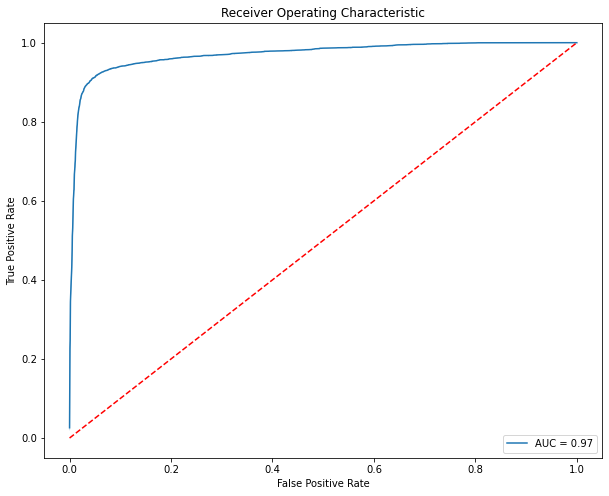

In [216]:
fpr,tpr,_ = roc_curve(image_info_change['label'], image_info_change['pred'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [217]:
y_pred_class = list(map(lambda x:1 if x>=0.3 else 0, image_info_change['pred']))
print(classification_report(image_info_change['label'], y_pred_class))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     10151
           1       0.85      0.92      0.89      3975

    accuracy                           0.93     14126
   macro avg       0.91      0.93      0.92     14126
weighted avg       0.94      0.93      0.94     14126



In [218]:
def Prob2Score(prob, basePoint=600, PDO=30):
    #将概率转化成分数且为正整数
    y = np.log(prob/(1-prob))
    return (basePoint+int(PDO/np.log(2)*(y)))

In [219]:
image_info_change['score'] = image_info_change['pred'].apply(Prob2Score)

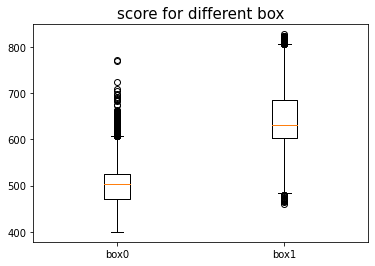

In [220]:
box0 = image_info_change[image_info_change['label']==0]['score']
box1 = image_info_change[image_info_change['label']==1]['score']
plt.title('score for different box',fontsize=15)
labels = 'box0','box1'
plt.boxplot([box0,box1],labels=labels)
plt.show()

In [221]:
image_info_label['score'] = image_info_change['score']

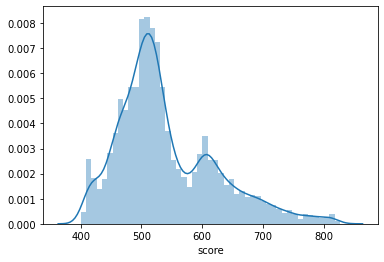

In [222]:
sns.distplot(image_info_label['score'])
plt.show()

In [223]:
image_info_label[image_info_label['score']>=600]['create_role_30_pay_sum'].sum() / image_info_label[image_info_label['score']>=600]['image_run_date_amount'].sum()

0.8631406041333206

In [224]:
image_info_label[image_info_label['score']<600]['create_role_30_pay_sum'].sum() / image_info_label[image_info_label['score']<600]['image_run_date_amount'].sum()

0.19627006952265413

In [225]:
image_info_label[image_info_label['score']<600]['create_role_30_pay_sum'].sum()

21627479.0

In [226]:
image_info_label['create_role_30_pay_sum'].sum()

192885318.0

In [309]:
import sklearn
import xgboost
import lightgbm

In [310]:
sklearn.__version__

'0.23.1'

In [311]:
xgboost.__version__

'1.1.1'

In [312]:
lightgbm.__version__

'2.3.1'